# Laplacian Associative Memory (LAM) - ALPHA

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

In [1]:
import sys
sys.path.append('..')

In [2]:
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from nn_npy import LAM
import libtools

---

#### DATA

In [4]:
img = np.array(PIL.Image.open("../data/images/coco/mesh.png").convert('L'), dtype=float)
# img = libtools.downsample(img, 2) # Downsample
img = img[:100,:100] # Crop
img /= np.max(img)

print('Image:', img.shape)
print('min:', f"{img.min():.2f}", 'max:', f"{img.max():.2f}")

Image: (100, 100)
min: 0.02 max: 1.00


---

In [5]:
f = np.fft.fft2(img) # Frequency transform
fshift = np.fft.fftshift(f) # Shift zero frequency component (DC-component)
power = np.abs(fshift) # Process complex numbers
phase = np.angle(fshift)

In [6]:
# Define radial distance
nx, ny = power.shape
x = np.arange(-power.shape[0]//2, power.shape[0]//2)
y = np.arange(-power.shape[1]//2, power.shape[1]//2)
X, Y = np.meshgrid(x, y)
dist = np.sqrt(X**2 + Y**2)

# Compute spatial frequency
hist, bins = np.histogram(dist.flatten(), bins=np.arange(dist.max()), weights=power.flatten())

count = hist[1:].argmax()
print('Freqency at which power is greatest:', count)

Freqency at which power is greatest: 12


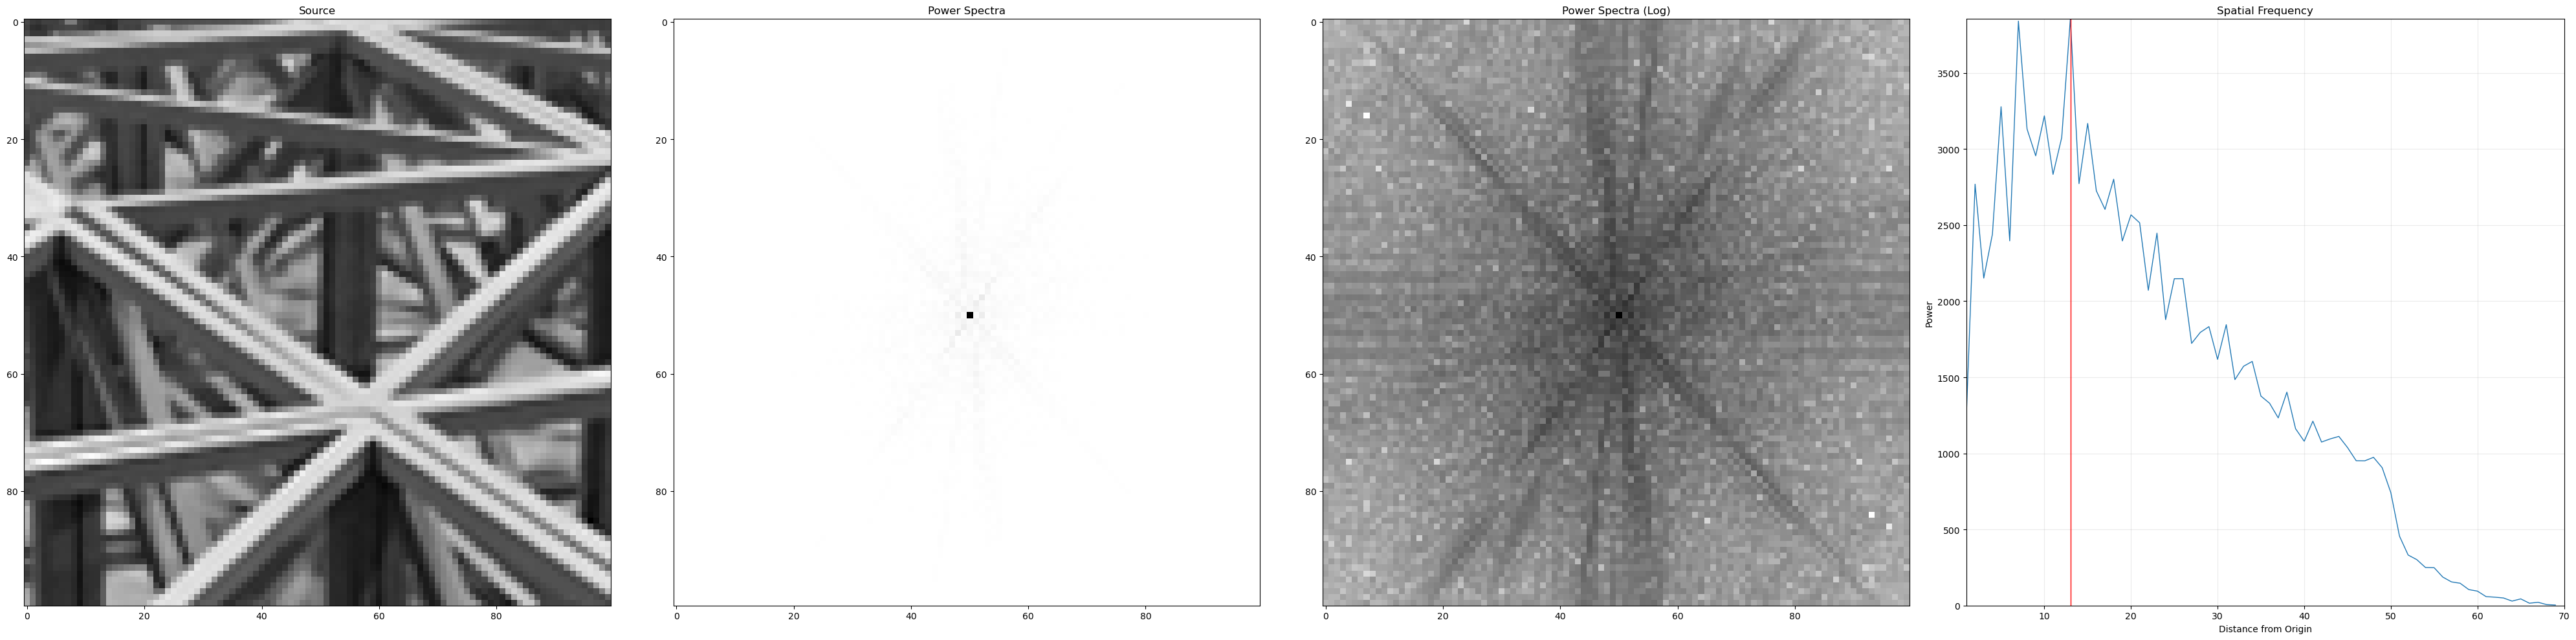

In [7]:
plt.figure(figsize=(40,10))
plt.subplot(1,4,1)
plt.imshow(img, 'gray')
plt.title('Source')

plt.subplot(1,4,2)
plt.imshow(power, 'binary')
plt.title('Power Spectra')

plt.subplot(1,4,3)
plt.imshow(np.log(power), 'binary')
plt.title('Power Spectra (Log)')

plt.subplot(1,4,4)
plt.plot(bins[:-1], hist, lw=1)
plt.vlines(count+1, 0, hist[1:].max(), linewidth=1, color='r')
plt.title('Spatial Frequency')
plt.xlabel('Distance from Origin'), plt.ylabel('Power')
plt.xlim([1,int(dist.max())]), plt.ylim([0,int(hist[1:].max())])
plt.grid(alpha=0.25)
plt.tight_layout()

---

In [8]:
src = libtools.preference_map(16, count*2, img.shape[0]) # x2 power of spatial frequency FFT
# np.save('../data/mat/SOM_orient_v2.npy', src)
# src = np.load('../data/mat/SOM_orient_v2.npy')

print('Map:', src.shape)
print('min:', f"{src.min():.2f}", 'max:', f"{src.max():.2f}")

Map: (100, 100)
min: 0.00 max: 6.28


In [9]:
features = libtools.gabor_conv(img, src, step=int(count)) # Power of spatial frequency FFT (No multiplicative factor)
features /= np.max(features)

print('Features:', features.shape)
print('min:', f"{features.min():.2f}", 'max:', f"{features.max():.2f}")

Features: (100, 100)
min: 0.00 max: 1.00


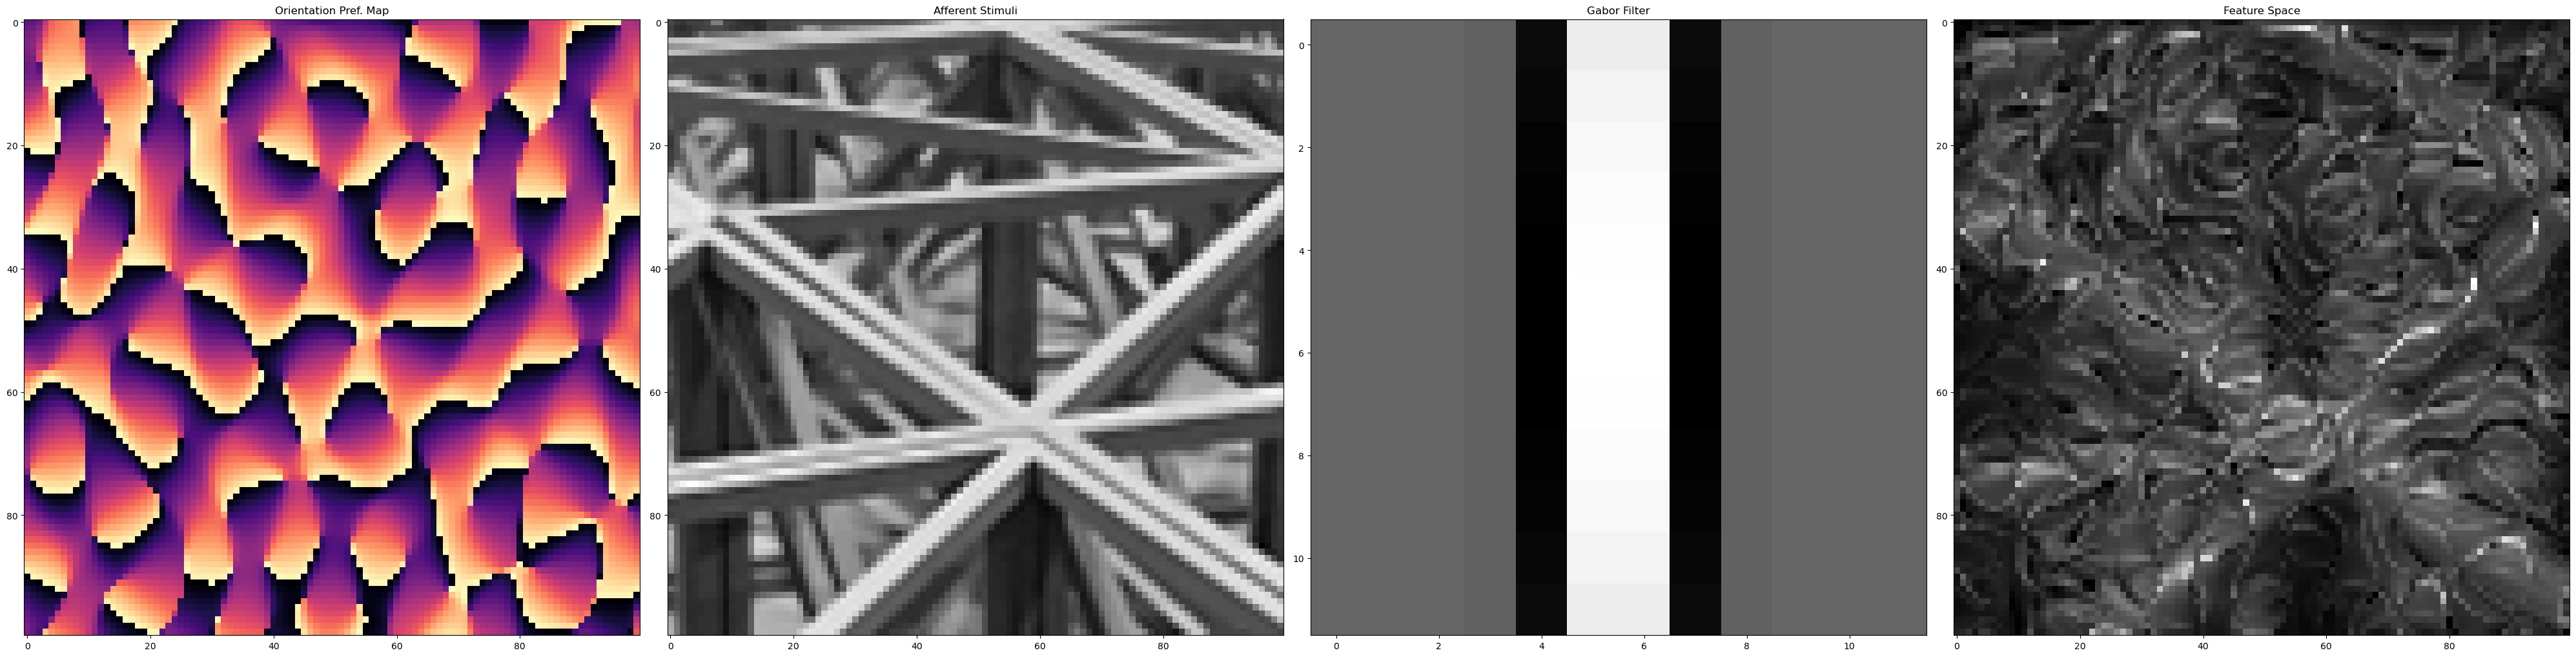

In [10]:
plt.figure(figsize=(40,10))
plt.subplot(1,4,1)
plt.imshow(src, 'magma')
plt.title('Orientation Pref. Map')

plt.subplot(1,4,2)
plt.imshow(img, 'gray')
plt.title('Afferent Stimuli')

plt.subplot(1,4,3)
plt.imshow(libtools.gabor_filter(1,10,0, samples=int(count)), 'gray')
plt.title('Gabor Filter')

plt.subplot(1,4,4)
plt.imshow(features, 'gray')
plt.title('Feature Space')
plt.tight_layout()

---

### HYPER-PARAMETERS

In [11]:
N = 128**2                              # Units | Default: 30000
prob = 0.1                              # Sparsity
eta = 0.01                              # Epsilon / Learning rate
simlen = 3000                           # Steps / Epochs
gamma = 0.6                             # Inhibition ratio
norm_mode = 'asym'                      # Asymmetric Normalisation
P = src.shape[0] * src.shape[1]         # N Nodes

sigmaX = 1e-5                           # Spatial Gaussian Scale
sigmaA = 0.1                            # Angular Gaussian Scale

# Init condition (Center cell/pixel)
start_node = int(int(src.shape[0]/2) * src.shape[1] + int(src.shape[0]/2))

print('Nodes:', N)
print("Neurons:", P)
print('Start node:', start_node)
print(f"{P * 0.138:.2f} point attactors")

Nodes: 16384
Neurons: 10000
Start node: 5050
1380.00 point attactors


---

### COMPUTE

In [12]:
W = libtools.construct_SLAM(src, sigmaX, sigmaA)

In [13]:
graph = LAM(N, P, prob, W, gamma, "asym")

In [14]:
init_state = libtools.set_state(graph, features, 0.095)
print("Sparsity:", np.sum(init_state/np.size(init_state)))

Sparsity: 0.11322021484375


In [15]:
a_hist, m_hist = [],[]
a_arr = np.arange(-1.0, 1.1, 0.1) # Alpha | Ratio between local and global inhibition

for i in tqdm(range(len(a_arr))):
    a = np.around(a_arr[i], decimals=1)
    print("Alpha:", a)

    m_log, _, e_log = graph.simulate_single(a, eta, simlen, start_node, init_state.copy())
    m = m_log[-1,:].copy()

    a_hist.append(a)
    m_hist.append(m)

  0%|          | 0/21 [00:00<?, ?it/s]

Alpha: -1.0
Using feature-based initial condition


  5%|▍         | 1/21 [06:57<2:19:18, 417.94s/it]

Alpha: -0.9
Using feature-based initial condition


 10%|▉         | 2/21 [14:12<2:15:24, 427.61s/it]

Alpha: -0.8
Using feature-based initial condition


 14%|█▍        | 3/21 [21:14<2:07:33, 425.19s/it]

Alpha: -0.7
Using feature-based initial condition


 19%|█▉        | 4/21 [28:21<2:00:37, 425.74s/it]

Alpha: -0.6
Using feature-based initial condition


 24%|██▍       | 5/21 [35:36<1:54:28, 429.27s/it]

Alpha: -0.5
Using feature-based initial condition


 29%|██▊       | 6/21 [42:44<1:47:10, 428.70s/it]

Alpha: -0.4
Using feature-based initial condition


 33%|███▎      | 7/21 [49:58<1:40:28, 430.60s/it]

Alpha: -0.3
Using feature-based initial condition


 38%|███▊      | 8/21 [57:05<1:33:00, 429.29s/it]

Alpha: -0.2
Using feature-based initial condition


 43%|████▎     | 9/21 [1:04:02<1:25:07, 425.64s/it]

Alpha: -0.1
Using feature-based initial condition


 48%|████▊     | 10/21 [1:10:58<1:17:27, 422.52s/it]

Alpha: -0.0
Using feature-based initial condition


 52%|█████▏    | 11/21 [1:17:51<1:09:55, 419.54s/it]

Alpha: 0.1
Using feature-based initial condition


 57%|█████▋    | 12/21 [1:24:56<1:03:10, 421.18s/it]

Alpha: 0.2
Using feature-based initial condition


 62%|██████▏   | 13/21 [1:31:58<56:12, 421.51s/it]  

Alpha: 0.3
Using feature-based initial condition


 67%|██████▋   | 14/21 [1:39:04<49:19, 422.78s/it]

Alpha: 0.4
Using feature-based initial condition


 71%|███████▏  | 15/21 [1:46:11<42:24, 424.01s/it]

Alpha: 0.5
Using feature-based initial condition


 76%|███████▌  | 16/21 [1:53:04<35:04, 420.98s/it]

Alpha: 0.6
Using feature-based initial condition


 81%|████████  | 17/21 [2:00:27<28:29, 427.46s/it]

Alpha: 0.7
Using feature-based initial condition


 86%|████████▌ | 18/21 [2:07:37<21:24, 428.09s/it]

Alpha: 0.8
Using feature-based initial condition


 90%|█████████ | 19/21 [2:14:45<14:16, 428.21s/it]

Alpha: 0.9
Using feature-based initial condition


 95%|█████████▌| 20/21 [2:21:42<07:04, 424.70s/it]

Alpha: 1.0
Using feature-based initial condition


100%|██████████| 21/21 [2:29:18<00:00, 426.60s/it]


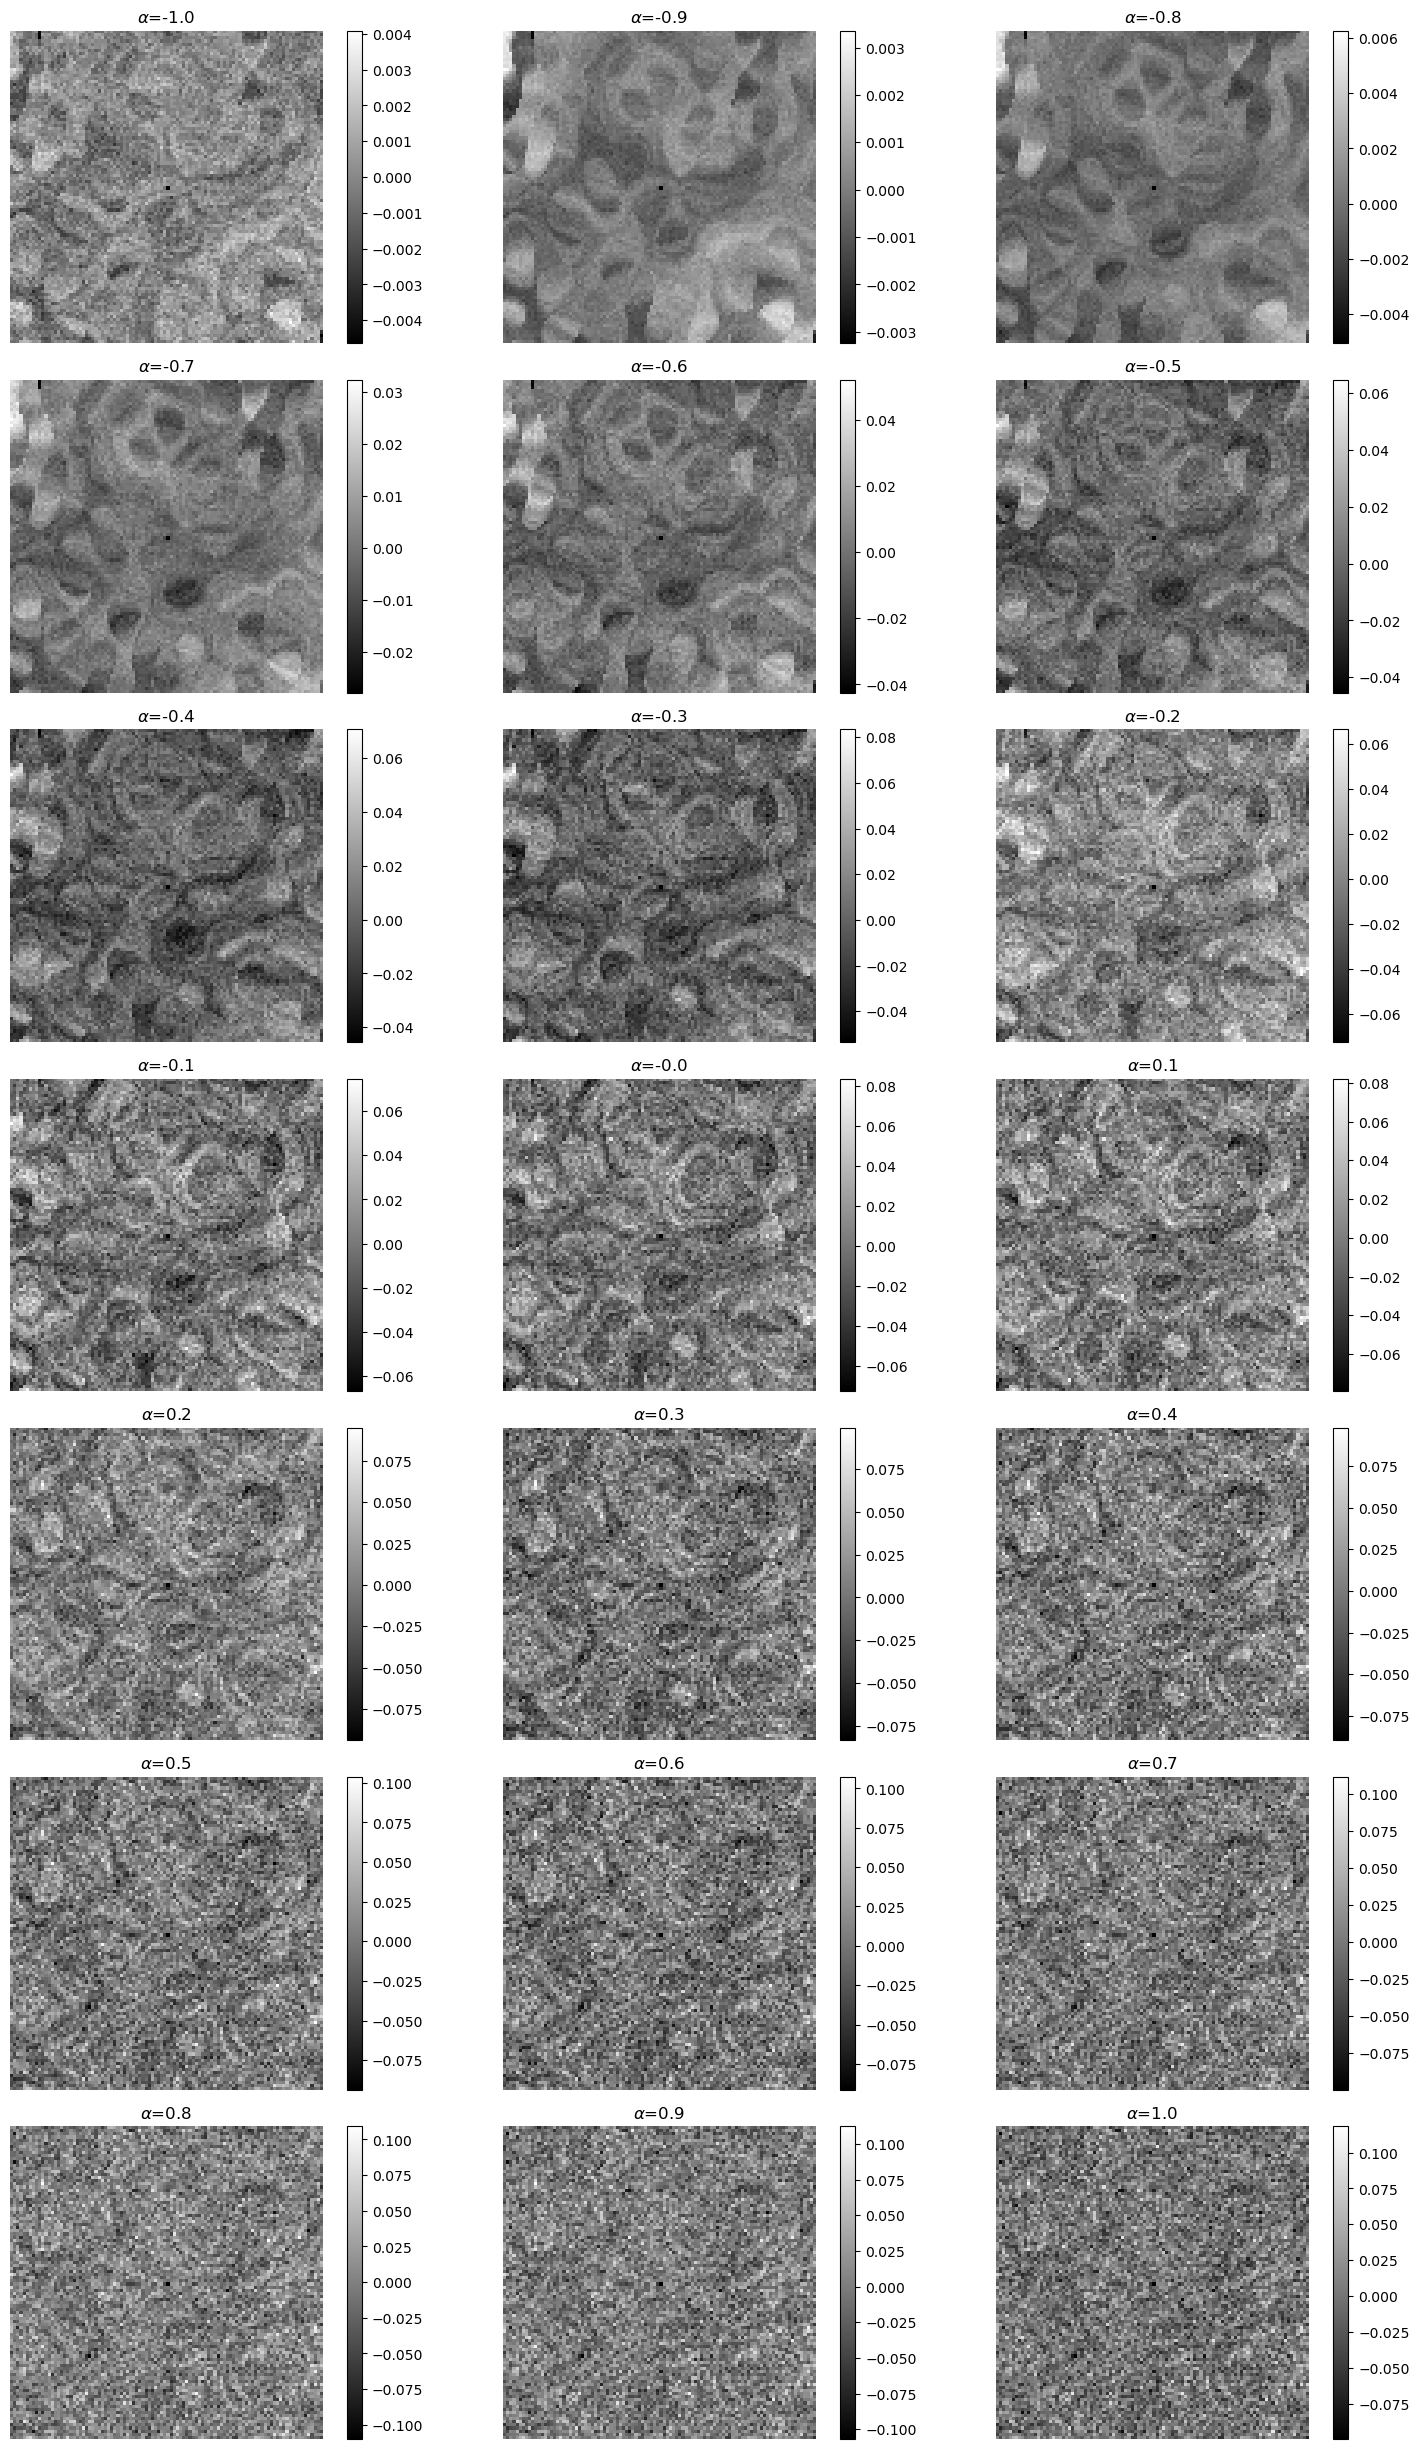

In [16]:
plt.figure(figsize=(15,70))
for a_ind in range(len(a_arr)):
    a = np.around(a_arr[a_ind], decimals=1)
    m = m_hist[a_ind]
    m[start_node] = m.min()

    plt.subplot(20, 3, a_ind+1)
    plt.imshow(m.reshape(src.shape), cmap="gray", vmin=np.min(m), vmax=np.max(m))
    plt.axis("off"), plt.colorbar()
    plt.title(r"$\alpha$="+str(a))
    plt.tight_layout()

---

In [17]:
Na = len(a_arr)
max_overlap = np.zeros(Na)
Nactive = np.zeros(Na)

for a_ind in range(Na):
    m = m_hist[a_ind]
    max_m = np.max(m)
    max_overlap[a_ind] = max_m
    Nactive[a_ind] = np.mean(np.sum((m > 0.5*max_m) * (m > 0.0), axis=0))

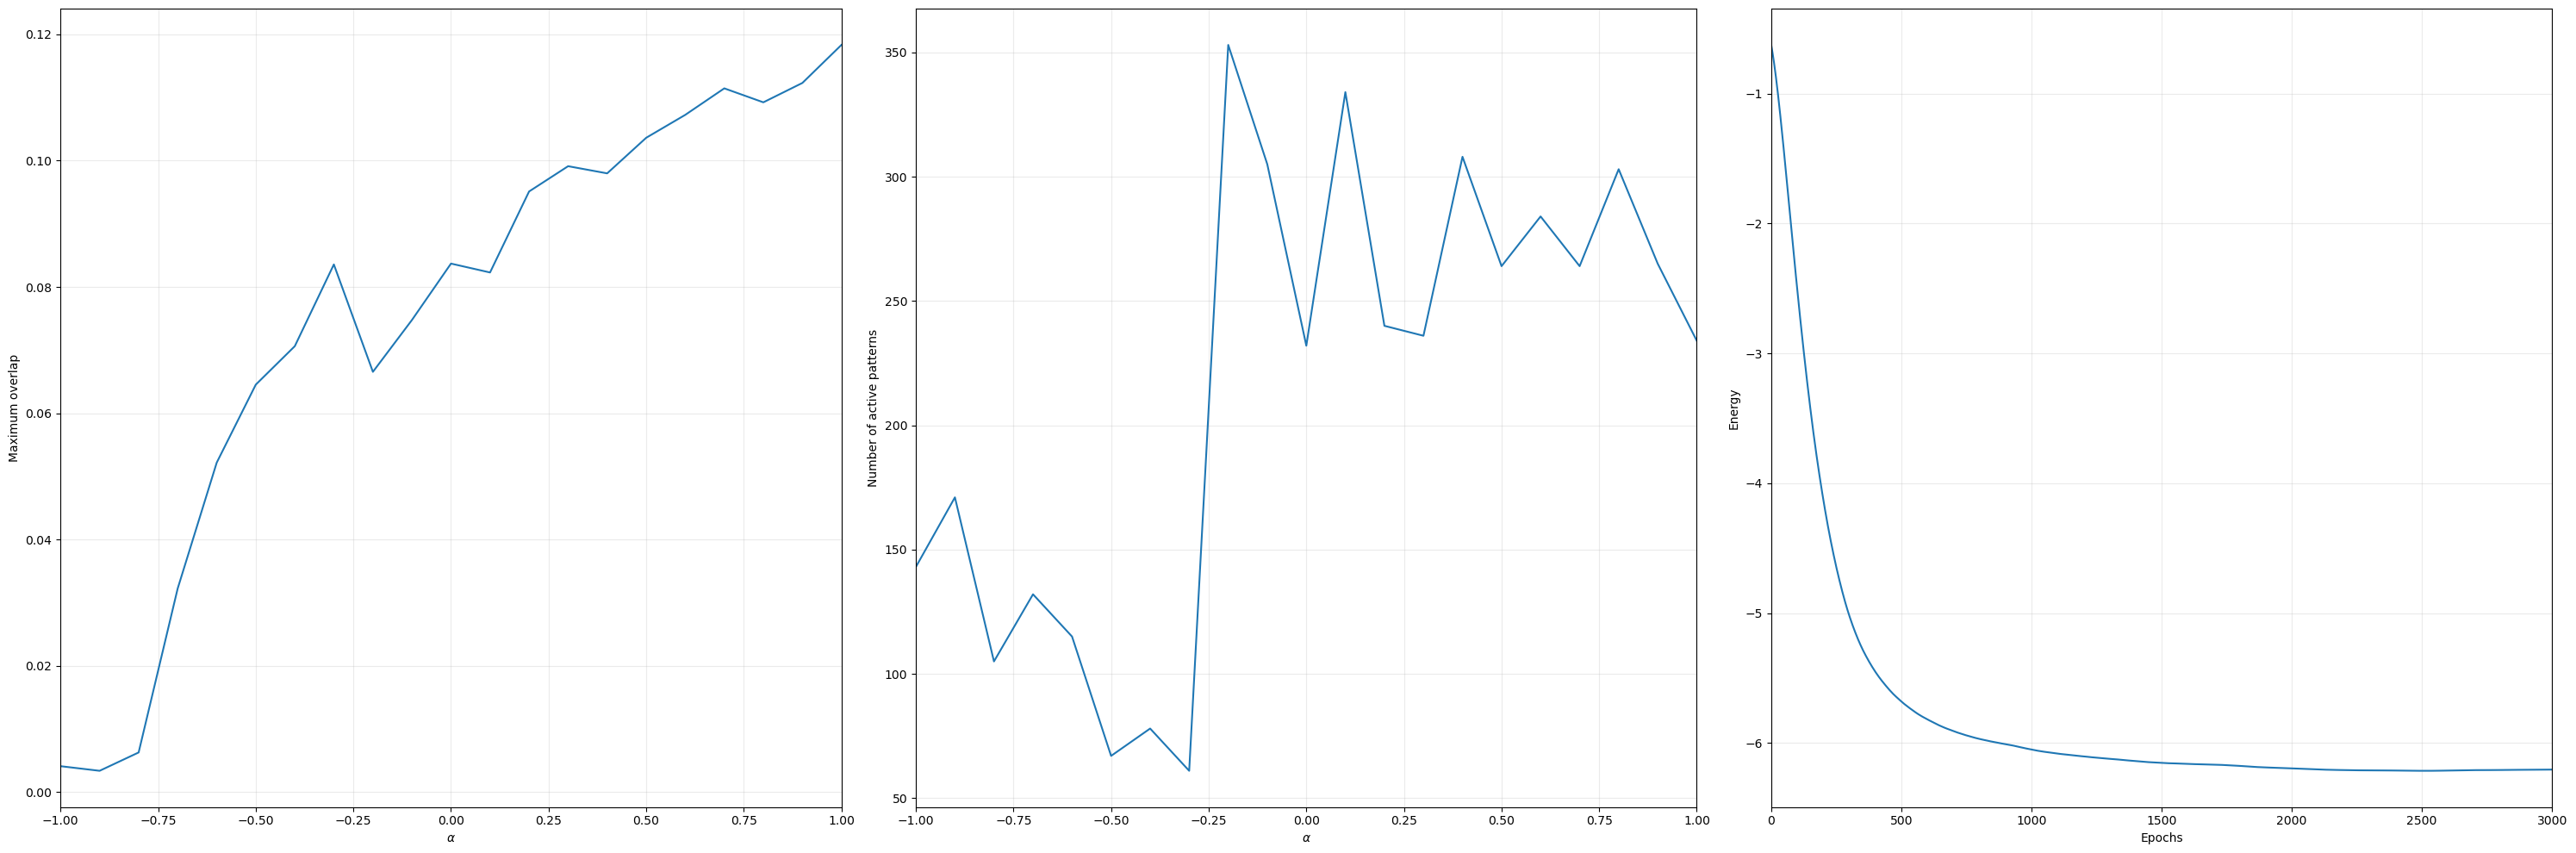

In [18]:
xlim=[np.min(a_arr), np.max(a_arr)]

# Max. overlap
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.plot(a_arr, max_overlap)
plt.xlabel(r"$\alpha$"), plt.ylabel("Maximum overlap")
plt.xlim(xlim)
plt.grid('on', alpha=0.25)

# Number of patterns
plt.subplot(1,3,2)
plt.plot(a_arr, Nactive)
plt.xlabel(r"$\alpha$"), plt.ylabel("Number of active patterns")
plt.xlim(xlim)
plt.grid('on', alpha=0.25)

# Energy
plt.subplot(1,3,3)
plt.plot(e_log)
plt.xlabel("Epochs"), plt.ylabel("Energy")
plt.xlim(0,simlen)
plt.grid('on', alpha=0.25)
plt.tight_layout()